## In class Cross-valiation and Bootstrap

### Predict the profit of startups using Regression models
Just do the cross-validation we will do the bootstrap in class

,onehotencoder__State_California,onehotencoder__State_Florida,onehotencoder__State_New York,remainder__R&D Spend,remainder__Administration,remainder__Marketing Spend,remainder__Profit
0,0.0,0.0,1.0,165349.20,136897.80,471784.10,192261.83
1,1.0,0.0,0.0,162597.70,151377.59,443898.53,191792.06
2,0.0,1.0,0.0,153441.51,101145.55,407934.54,191050.39
3,0.0,0.0,1.0,144372.41,118671.85,383199.62,182901.99
4,0.0,1.0,0.0,142107.34,91391.77,366168.42,166187.94


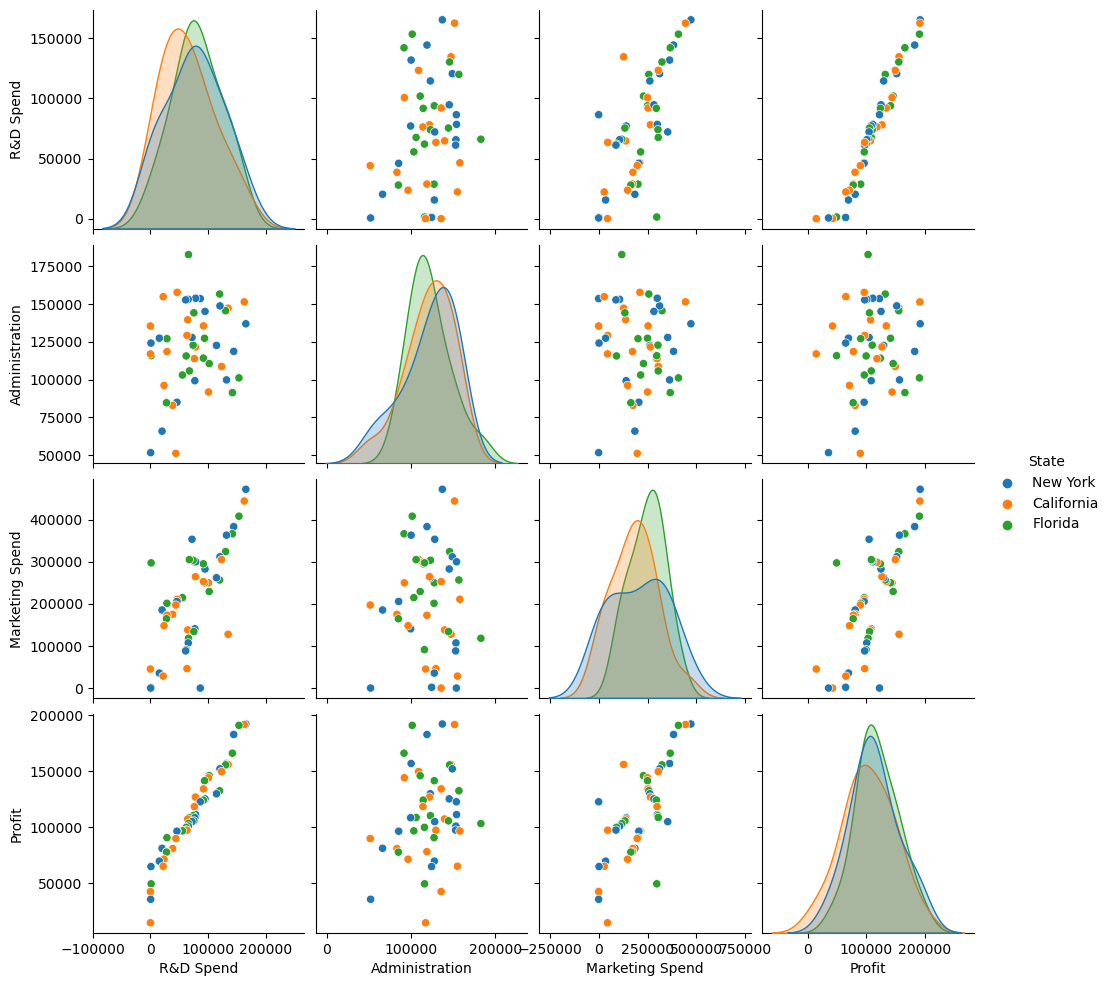

In [306]:
%matplotlib inline

from tkinter.font import names
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneOut
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer
import scipy.stats as st

# can just do 50:50 train and testing
df = pd.read_csv('data/50_Startups.csv')
# print(df)

transformer = make_column_transformer(
    (OneHotEncoder(), ['State']),
    remainder='passthrough')

transformed = transformer.fit_transform(df)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

sns.pairplot(df,hue = 'State')

transformed_df.head()
# df.head()

# I don't need to regularize I don't think
# d = preprocessing.normalize(transformed_df,axis = 0)
# scaled_df = pd.DataFrame(d, columns=transformed_df.columns)

# # If I wanted to take out by each state
# scaled_df.head()


Looking at the pair plot above it looks like Administration does not have a good correlation with Profit so I will not create a model of it. It looks like R&D spend and marketing spend have linear or non-linear relationships with profit so I will look at cross-validations using them for separate models.

In [307]:
# # Split into training and test sets 50:50
# train, test = train_test_split(transformed_df ,test_size = 0.5)

# # split into targets and inputs
# train_inputs = train.iloc[:,:-1]
# train_target = train.iloc[:,-1].values.reshape(len(test),1)

# test_inputs = test.iloc[:,:-1]
# test_target = test.iloc[:,-1].values.reshape(len(test),1)
# # print(train_inputs.columns)

# RD_df = pd.DataFrame(transformed_df['remainder__R&D Spend'].values)
# RD_train_inputs = pd.DataFrame(train_inputs['remainder__R&D Spend'].values)
# # print(RD_train_inputs.values.ndim)


# # print(type(train_inputs['remainder__R&D Spend'].values))
# # print(RD_train_inputs)
# RD_test_inputs = pd.DataFrame(test_inputs['remainder__R&D Spend'].values)

# marketing_df = pd.DataFrame(transformed_df['remainder__Marketing Spend'].values)
# marketing_train_inputs = pd.DataFrame(train_inputs['remainder__Marketing Spend'].values)
# marketing_test_inputs = pd.DataFrame(test_inputs['remainder__Marketing Spend'].values)


Looking at a linear regression and a polynomial Regression of Profit vs R&D spending

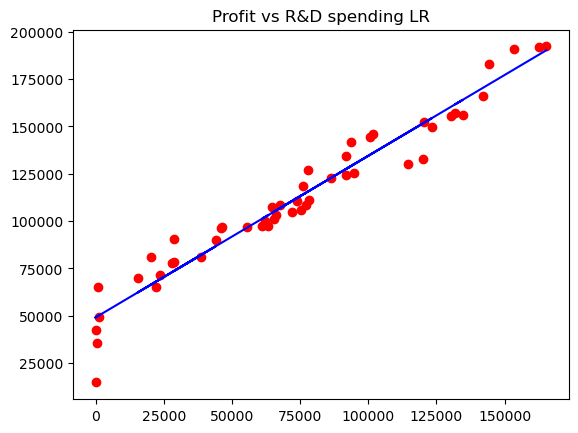

R^2 value of linear model: 0.947


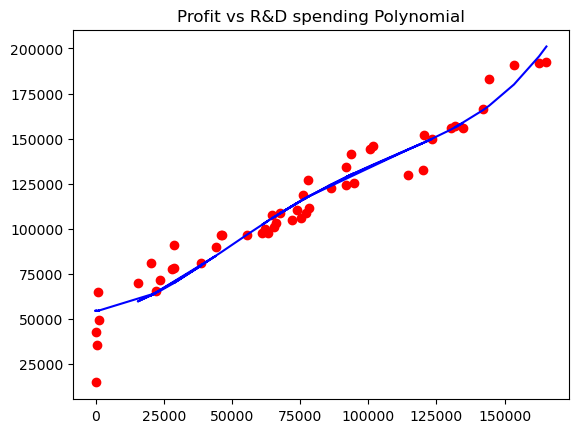

R^2 value of polynomial model: 0.934


In [308]:
X = transformed_df[['remainder__R&D Spend']]
y = transformed_df[['remainder__Profit']]

lin_reg = LinearRegression()
lin_reg.fit(X,y)
 
# visualising the linear regression model
plt.scatter(X,y, color='red')
plt.plot(X, lin_reg.predict(X),color='blue')
plt.title("Profit vs R&D spending LR")
plt.show()

print(f"R^2 value of linear model: {lin_reg.score(X,y):.3f}")
 
 
# visualising polynomial regression
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X)
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)
  
plt.scatter(X,y, color='red') 
  
plt.plot(X, lin_reg2.predict(poly_reg.fit_transform(X)),color='blue') 
plt.title("Profit vs R&D spending Polynomial")
plt.show()

print(f"R^2 value of polynomial model: {lin_reg2.score(X_poly,y):.3f}")



### Cross-validation

Implementation for a ten fold cross validation function

In [313]:
# X = transformed_df[['remainder__R&D Spend']]
# y = transformed_df[['remainder__Profit']]

# # visualising polynomial regression
# poly_reg = PolynomialFeatures(degree=4)
# X_poly = poly_reg.fit_transform(X)
# lin_reg2 = LinearRegression()
# lin_reg2.fit(X_poly,y)
  
# plt.scatter(X,y, color='red') 
  
# plt.plot(X, lin_reg2.predict(poly_reg.fit_transform(X)),color='blue') 
# plt.title("Profit vs R&D spending Polynomial")
# plt.show()

# print(f"R^2 value of polynomial model: {lin_reg2.score(X_poly,y):.3f}")


def ten_fold_cross_validation(data,num_degree):
    # create the amount of folds you want
    k_folds = KFold(n_splits=10,shuffle=True)
    avg_train_scores = []
    avg_test_scores = []

    X = pd.DataFrame(data.iloc[:,0])
    # print(type(X))
    y = pd.DataFrame(data.iloc[:,1])
    # print(y)

    # go through it as many times as num_degree
    for i in range(1,num_degree):
        poly = PolynomialFeatures(degree = i+1)
        X_poly = poly.fit_transform(X)
        train_scores = []
        test_scores = []
       
        # use the train to train and the validate to test
        for train_index, valid_index in k_folds.split(data):
            # print(f"Train index: {train_index}\nValid index: {valid_index}")
            lr = LinearRegression()
            lr.fit(X_poly, y)

            train_set = pd.DataFrame(y.iloc[train_index])
            valid_set = pd.DataFrame(y.iloc[valid_index])
            # print(y.iloc[train_index])

            # gives the RSS of the data set
            train_scores.append(lr.score(X_poly[train_index],train_set))
            test_scores.append(lr.score(X_poly[valid_index], valid_set))


        avg_train_scores.append(sum(test_scores)/10)
        avg_test_scores.append(sum(train_scores)/10)

    return avg_train_scores, avg_test_scores



Testing the implementation
### format this better

In [314]:
X = transformed_df[['remainder__R&D Spend']]
y = transformed_df[['remainder__Profit']]
RD_df = pd.concat([X,y], axis=1)

train_scores, test_scores = ten_fold_cross_validation(RD_df,9)
print(train_scores)
print(test_scores)


[0.8791108493930523, 0.9189840119339348, 0.9182226788329727, 0.845595001610883, 0.8125371531539886, 0.8197097324822586, 0.6950288358338741, 0.6055016688097143]
[0.9465229921507149, 0.9539087863643863, 0.9337366475831667, 0.9086270681049033, 0.8765923584865188, 0.8345390522817226, 0.7873517191958117, 0.7425380499733131]
